# Create a covariance matrix for Cls of galaxy, weak lensing and CMB lensing 

The CovarianceCalculator does not work for the Gaussian NMT Fourier configuration if we do not provide the binning scheme as a Nmt object in the configuration. 

This is a problem because we cannot put the NmtBin object in the .yaml file, we have to create it before calling the CovarianceCalculator. 

One solution would be to retrieve the binning scheme from the sacc file itself. 
But the binning is different in sacc, it allows each multipole to be in several bins, with some weights, while the Nmt binning affects only one bin for each multipole. 

FIX: It seems that the Nmt convention for the bin interval is like for python arrays, it excludes the upper bound, while for sacc it includes it ?
For instance the ell effective for the bin [0, 6] is 2.5 for Nmtand 3 for the sacc file? 

In this testing notebook, we are limited in multipole range by the Nside of the mask for DES which is of only 32. 
Maybe we can upgrade a bit the resolution of this mask to get to higher multipoles. 
Also I put the same mask for the CMB lensing, need to put a more realistic one. 

Finally the noise curves for the CMB lensing experiment should be loaded in the cache, for now I put it as a constant.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sacc
from sacc import data_types
import numpy as np
import os
import tjpcov
from tjpcov.covariance_calculator import CovarianceCalculator
import healpy as hp
import pymaster as nmt
from matplotlib import pyplot as plt

In [3]:
from tjpcov.covariance_io import CovarianceIO


In [4]:
notebook_dir = os.getcwd()

In [5]:
# Useful functions from TJPCov/tests/test_covariance_fourier_gaussian_nmt.py

def get_config(fname):
    return CovarianceIO._parse(fname)

def get_nmt_bin(nside, lmax=None):
    if lmax is None: 
        lmax = 3*nside
    assert lmax< 3*nside +1
    bpw_edges = np.array(
        [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96]
    )
    if lmax != 3 * nside:
        # lmax + 1 because the last ell is not included
        bpw_edges = bpw_edges[bpw_edges < lmax + 1]
        bpw_edges[-1] = lmax + 1

    return nmt.NmtBin.from_edges(bpw_edges[:-1], bpw_edges[1:])


In [6]:
config_yml = os.path.join(notebook_dir, 'conf_covariance_test_namaster.yml')
config = get_config(config_yml)


In [7]:
# Sacc file generated from the CMB_LSS_write notebook 

fn_sacc = config['tjpcov']['sacc_file']
s = sacc.Sacc.load_fits(fn_sacc)
dts = s.get_data_types()
    
for n, t in s.tracers.items():
    print(t.name, t.quantity, type(t))  
    
# Type of power spectra
data_types = np.unique([d.data_type for d in s.data])
print("Data types: ", data_types)

# Tracer combinations
print("Tracer combinations: ", s.get_tracer_combinations())

# Data size
print("Size: ", s.mean.size)


for dt in dts:
    print(dt)
    tracer_sets = s.get_tracer_combinations(dt)
    print(tracer_sets)


ck cmb_convergence <class 'sacc.tracers.MapTracer'>
gc galaxy_density <class 'sacc.tracers.NZTracer'>
wl galaxy_shear <class 'sacc.tracers.NZTracer'>
Data types:  ['cl_00' 'cl_0b' 'cl_0e' 'cl_bb' 'cl_eb' 'cl_ee']
Tracer combinations:  [('ck', 'ck'), ('gc', 'ck'), ('gc', 'gc'), ('gc', 'wl'), ('wl', 'ck'), ('wl', 'wl')]
Size:  160
cl_00
[('ck', 'ck'), ('gc', 'ck'), ('gc', 'gc')]
cl_0e
[('gc', 'wl'), ('wl', 'ck')]
cl_0b
[('gc', 'wl'), ('wl', 'ck')]
cl_ee
[('wl', 'wl')]
cl_eb
[('wl', 'wl')]
cl_bb
[('wl', 'wl')]


In [8]:
mask = hp.read_map(config['tjpcov']['mask_file']['gc'])

In [9]:
nside = hp.get_nside(mask)

In [14]:
nside

32

In [11]:
mask_lsst = hp.read_map('mask_lsst/map_for_paul.fits')

## Plot mask

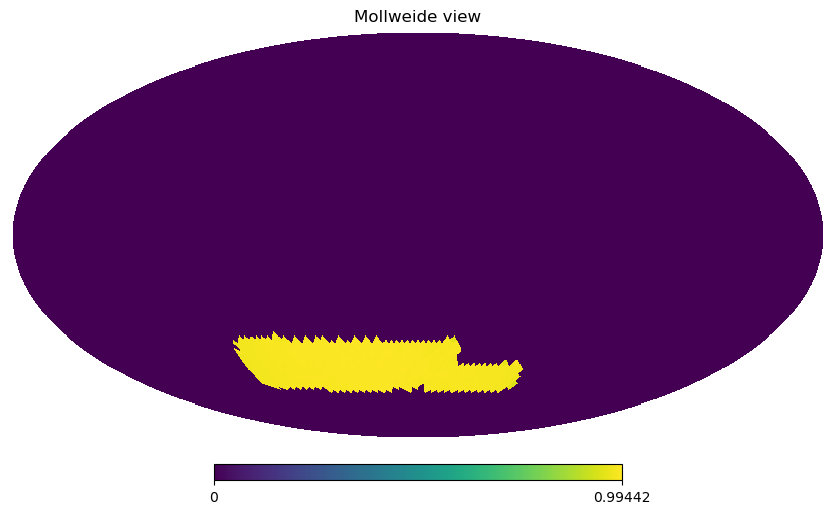

In [10]:
hp.mollview(mask)

In [13]:
hp.get_nside(mask_lsst)

64

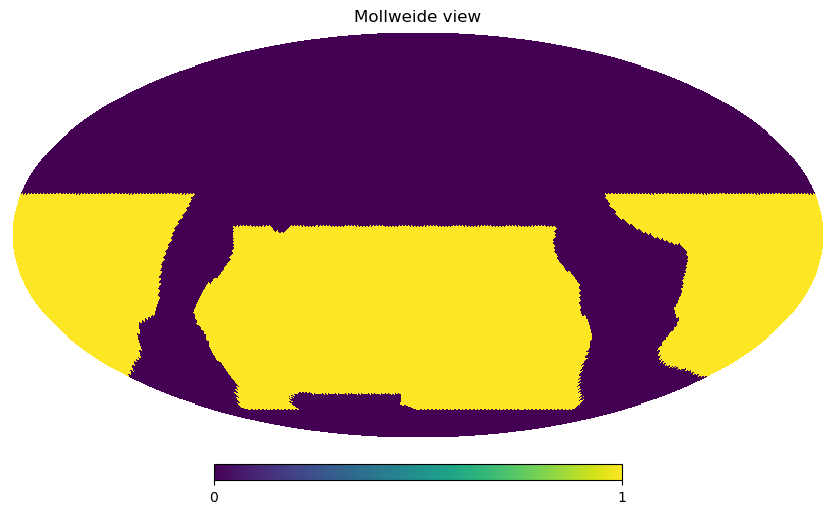

In [12]:
hp.mollview(mask_lsst)

In [10]:
bins = get_nmt_bin(nside)
config["tjpcov"]["binning_info"] = bins

In [11]:
cc = CovarianceCalculator(config)

In [12]:
cov = cc.get_covariance(use_coupled_noise=False)

Computing independent covariance blocks
Computing the blocks for independent workspaces
('ck', 'ck') ('ck', 'ck')
Loading saved covariance tmp/cov_ck_ck_ck_ck.npz
('gc', 'ck') ('gc', 'ck')
Loading saved covariance tmp/cov_gc_ck_gc_ck.npz
('gc', 'gc') ('gc', 'gc')
Loading saved covariance tmp/cov_gc_gc_gc_gc.npz
('gc', 'wl') ('gc', 'wl')
Loading saved covariance tmp/cov_gc_wl_gc_wl.npz
('wl', 'ck') ('wl', 'ck')
Loading saved covariance tmp/cov_wl_ck_wl_ck.npz
('wl', 'wl') ('wl', 'wl')
Loading saved covariance tmp/cov_wl_wl_wl_wl.npz
Computing the blocks for independent covariance workspaces
('ck', 'ck') ('gc', 'ck')
Loading saved covariance tmp/cov_ck_ck_gc_ck.npz
('ck', 'ck') ('gc', 'gc')
Loading saved covariance tmp/cov_ck_ck_gc_gc.npz
('ck', 'ck') ('gc', 'wl')
Loading saved covariance tmp/cov_ck_ck_gc_wl.npz
('ck', 'ck') ('wl', 'ck')
Loading saved covariance tmp/cov_ck_ck_wl_ck.npz
('ck', 'ck') ('wl', 'wl')
Loading saved covariance tmp/cov_ck_ck_wl_wl.npz
('gc', 'ck') ('gc', 'gc')
Lo

/Users/louis/Code/TJPCov/tjpcov/covariance_builder.py:888: UserWarning: Missing n_ell_coupled info for some tracers in the sacc file. You will have to pass it withthe cache
  warnings.warn(
/opt/miniconda3/envs/tjpcov0p4/lib/python3.11/site-packages/sacc/sacc.py:378: UserWarning: Empty index selected - maybe you should check the tracer order?
  warnings.warn("Empty index selected - maybe you "


('gc', 'gc') ('gc', 'wl')
('gc', 'gc') ('wl', 'ck')
('gc', 'gc') ('wl', 'wl')
('gc', 'wl') ('wl', 'ck')
('gc', 'wl') ('wl', 'wl')
('wl', 'ck') ('wl', 'wl')


In [13]:
bins.get_effective_ells()

array([ 2.5,  8.5, 14.5, 20.5, 26.5, 32.5, 38.5, 44.5, 50.5, 56.5, 62.5,
       68.5, 74.5, 80.5, 86.5, 92.5])

/var/folders/k2/pz579q490y94_cj44cpv_5l80000gn/T/ipykernel_48209/609981110.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(np.abs(cov)))


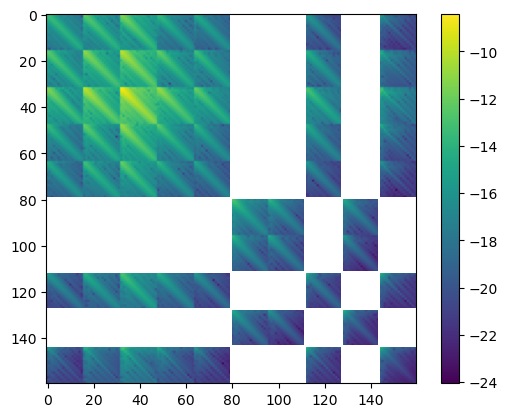

In [14]:
plt.imshow(np.log10(np.abs(cov)))
plt.colorbar()
plt.show()